# Brazilian E-commerce Data Analysis

This notebook imports all CSV files from the Brazilian e-commerce dataset and creates a table relationship diagram to understand the data structure.

## Dataset Overview
The dataset contains information about orders, customers, products, sellers, payments, and reviews from a Brazilian e-commerce platform.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import networkx as nx
import os
from pathlib import Path

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Define data directory and file paths
data_dir = Path("data")

# Dictionary to store all datasets
datasets = {}

# List all CSV files in the data directory
csv_files = {
    'customers': 'olist_customers_dataset.csv',
    'geolocation': 'olist_geolocation_dataset.csv',
    'order_items': 'olist_order_items_dataset.csv',
    'order_payments': 'olist_order_payments_dataset.csv',
    'order_reviews': 'olist_order_reviews_dataset.csv',
    'orders': 'olist_orders_dataset.csv',
    'products': 'olist_products_dataset.csv',
    'sellers': 'olist_sellers_dataset.csv',
    'product_category_translation': 'product_category_name_translation.csv'
}

# Import all CSV files
for name, filename in csv_files.items():
    file_path = data_dir / filename
    if file_path.exists():
        datasets[name] = pd.read_csv(file_path)
        print(f"✓ Loaded {name}: {datasets[name].shape}")
    else:
        print(f"✗ File not found: {filename}")

print(f"\nTotal datasets loaded: {len(datasets)}")

✓ Loaded customers: (99441, 5)
✓ Loaded geolocation: (1000163, 5)
✓ Loaded geolocation: (1000163, 5)
✓ Loaded order_items: (112650, 7)
✓ Loaded order_payments: (103886, 5)
✓ Loaded order_items: (112650, 7)
✓ Loaded order_payments: (103886, 5)
✓ Loaded order_reviews: (99224, 7)
✓ Loaded order_reviews: (99224, 7)
✓ Loaded orders: (99441, 8)
✓ Loaded products: (32951, 9)
✓ Loaded sellers: (3095, 4)
✓ Loaded product_category_translation: (71, 2)

Total datasets loaded: 9
✓ Loaded orders: (99441, 8)
✓ Loaded products: (32951, 9)
✓ Loaded sellers: (3095, 4)
✓ Loaded product_category_translation: (71, 2)

Total datasets loaded: 9


In [3]:
# Display basic information about each dataset
print("=== DATASET OVERVIEW ===\n")

for name, df in datasets.items():
    print(f"📊 {name.upper().replace('_', ' ')}")
    print(f"   Shape: {df.shape}")
    print(f"   Columns: {list(df.columns)}")
    print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print("-" * 80)

=== DATASET OVERVIEW ===

📊 CUSTOMERS
   Shape: (99441, 5)
   Columns: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']
   Memory usage: 26.59 MB
--------------------------------------------------------------------------------
📊 GEOLOCATION
   Shape: (1000163, 5)
   Columns: ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']
   Memory usage: 129.38 MB
--------------------------------------------------------------------------------
📊 ORDER ITEMS
   Shape: (112650, 7)
   Columns: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
   Memory usage: 35.99 MB
--------------------------------------------------------------------------------
📊 ORDER PAYMENTS
   Shape: (103886, 5)
   Columns: ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']
   Memory usage: 16.23 MB
-----------------------

In [4]:
# Analyze potential relationships between tables by examining column names
print("=== POTENTIAL TABLE RELATIONSHIPS ===\n")

# Define potential foreign key relationships based on column names
relationships = []

# Check for matching columns that could indicate relationships
for table1_name, table1_df in datasets.items():
    for table2_name, table2_df in datasets.items():
        if table1_name != table2_name:
            # Find common columns
            common_columns = set(table1_df.columns) & set(table2_df.columns)
            
            # Look for columns that might be foreign keys
            for col in common_columns:
                if col.endswith('_id') or col in ['customer_id', 'order_id', 'product_id', 'seller_id']:
                    relationships.append({
                        'from_table': table1_name,
                        'to_table': table2_name,
                        'column': col
                    })

# Display identified relationships
for rel in relationships:
    print(f"🔗 {rel['from_table']} -> {rel['to_table']} (via {rel['column']})")

print(f"\nTotal relationships identified: {len(relationships)}")

=== POTENTIAL TABLE RELATIONSHIPS ===

🔗 customers -> orders (via customer_id)
🔗 order_items -> order_payments (via order_id)
🔗 order_items -> order_reviews (via order_id)
🔗 order_items -> orders (via order_id)
🔗 order_items -> products (via product_id)
🔗 order_items -> sellers (via seller_id)
🔗 order_payments -> order_items (via order_id)
🔗 order_payments -> order_reviews (via order_id)
🔗 order_payments -> orders (via order_id)
🔗 order_reviews -> order_items (via order_id)
🔗 order_reviews -> order_payments (via order_id)
🔗 order_reviews -> orders (via order_id)
🔗 orders -> customers (via customer_id)
🔗 orders -> order_items (via order_id)
🔗 orders -> order_payments (via order_id)
🔗 orders -> order_reviews (via order_id)
🔗 products -> order_items (via product_id)
🔗 sellers -> order_items (via seller_id)

Total relationships identified: 18


In [5]:
# Display detailed table schemas and sample data
print("=== DETAILED TABLE SCHEMAS ===\n")

for name, df in datasets.items():
    print(f"📋 {name.upper().replace('_', ' ')} TABLE")
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    
    # Display column information
    print("\nColumn Details:")
    for i, (col, dtype) in enumerate(zip(df.columns, df.dtypes), 1):
        null_count = df[col].isnull().sum()
        null_pct = (null_count / len(df)) * 100
        unique_count = df[col].nunique()
        print(f"  {i:2d}. {col:<30} | {str(dtype):<10} | Nulls: {null_count:>6} ({null_pct:5.1f}%) | Unique: {unique_count:>8}")
    
    # Display sample data
    print(f"\nSample Data (first 3 rows):")
    print(df.head(3).to_string(index=False))
    print("=" * 100)
    print()

=== DETAILED TABLE SCHEMAS ===

📋 CUSTOMERS TABLE
Shape: 99,441 rows × 5 columns

Column Details:
   1. customer_id                    | object     | Nulls:      0 (  0.0%) | Unique:    99441
   2. customer_unique_id             | object     | Nulls:      0 (  0.0%) | Unique:    96096
   3. customer_zip_code_prefix       | int64      | Nulls:      0 (  0.0%) | Unique:    14994
   4. customer_city                  | object     | Nulls:      0 (  0.0%) | Unique:     4119
   5. customer_state                 | object     | Nulls:      0 (  0.0%) | Unique:       27

Sample Data (first 3 rows):
                     customer_id               customer_unique_id  customer_zip_code_prefix         customer_city customer_state
06b8999e2fba1a1fbc88172c00ba8bc7 861eff4711a542e4b93843c6dd7febb0                     14409                franca             SP
18955e83d337fd6b2def6b18a428ac77 290c77bc529b7ac935b93aa66c333dc3                      9790 sao bernardo do campo             SP
4e7b3e00288586eb

## Key Insights - Database Structure

### Central Tables
- **Orders**: The central fact table containing order information
- **Customers**: Customer demographic and location data
- **Products**: Product catalog with categories
- **Sellers**: Seller information and locations

### Transaction Tables
- **Order Items**: Individual items within each order (many-to-many relationship)
- **Order Payments**: Payment methods and installment details
- **Order Reviews**: Customer feedback and ratings

### Reference Tables
- **Geolocation**: Geographic coordinates for zip codes
- **Product Category Translation**: Portuguese to English translations

### Main Relationships
1. `Orders` ↔ `Customers` (via customer_id)
2. `Orders` ↔ `Order Items` (via order_id) 
3. `Order Items` ↔ `Products` (via product_id)
4. `Order Items` ↔ `Sellers` (via seller_id)
5. `Orders` ↔ `Order Payments` (via order_id)
6. `Orders` ↔ `Order Reviews` (via order_id)

This structure follows a typical e-commerce star schema with Orders as the central fact table.

## Instacart Dataset Entity Relationship Diagram

The following section creates an entity relationship diagram for the Instacart Market Basket Analysis dataset, which is commonly used for recommendation systems and market basket analysis.

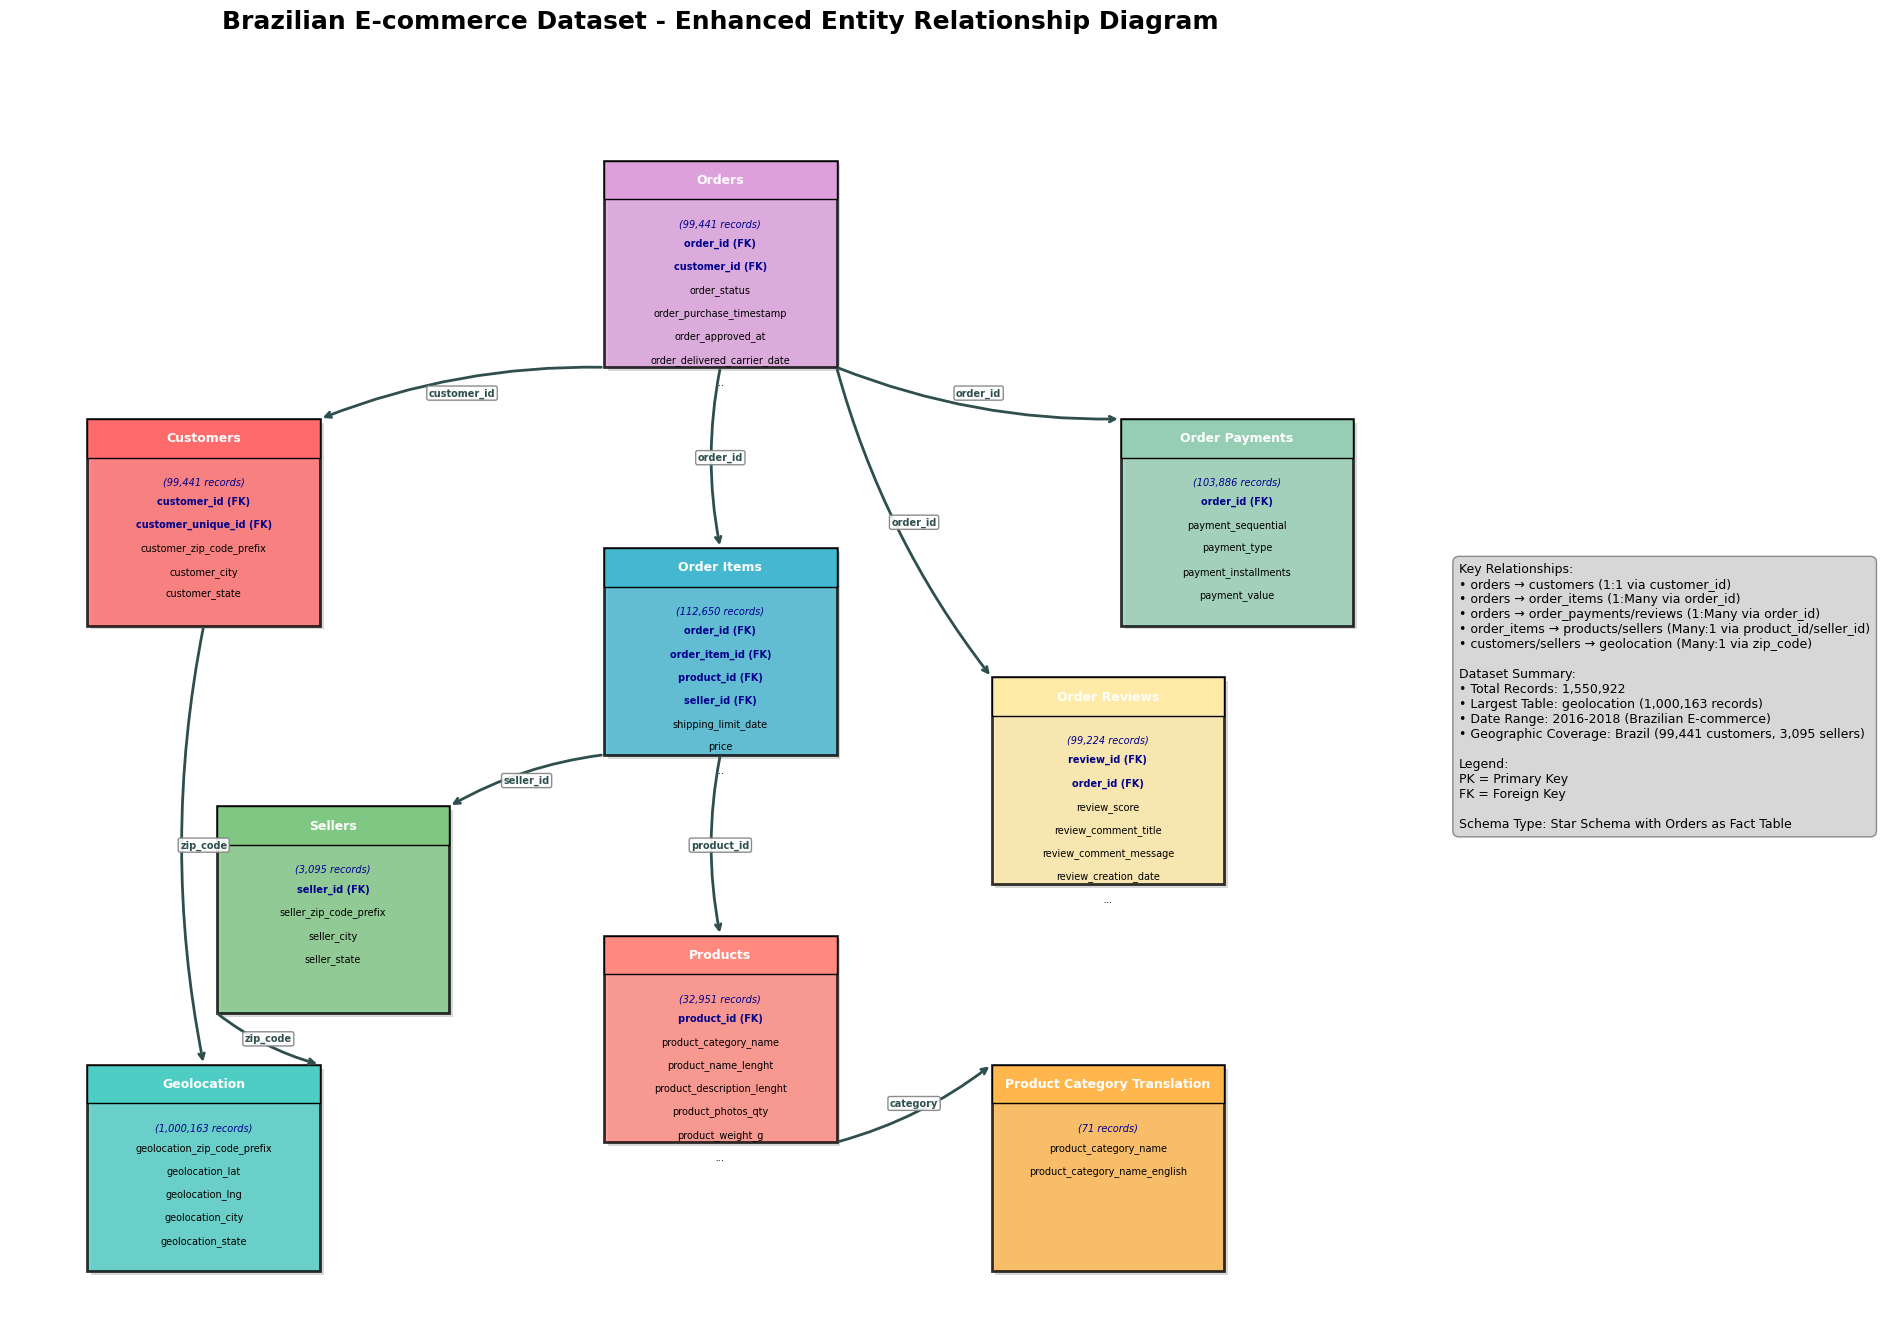

In [6]:
# Create Enhanced Entity Relationship Diagram for Brazilian E-commerce Dataset
def create_brazilian_ecommerce_er_diagram():
    """
    Creates a detailed entity relationship diagram for the Brazilian E-commerce dataset
    using the actual loaded data with table details and professional styling
    """
    fig, ax = plt.subplots(1, 1, figsize=(18, 14))

    # Define positions for each table (x, y coordinates between 0 and 1)
    positions = {
        'orders': (0.5, 0.8),
        'customers': (0.1, 0.6),
        'order_items': (0.5, 0.5),
        'order_payments': (0.9, 0.6),
        'order_reviews': (0.8, 0.4),
        'products': (0.5, 0.2),
        'sellers': (0.2, 0.3),
        'geolocation': (0.1, 0.1),
        'product_category_translation': (0.8, 0.1)
    }

    # Define table information using actual loaded data
    table_info = {}
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#FF8A80', '#81C784', '#FFB74D']
    
    for i, (name, df) in enumerate(datasets.items()):
        # Get key columns (those containing 'id')
        key_columns = [col for col in df.columns if 'id' in col.lower()]
        other_columns = [col for col in df.columns if 'id' not in col.lower()]
        
        # Format columns with PK/FK indicators
        formatted_columns = []
        for col in df.columns[:8]:  # Show first 8 columns
            if col.endswith('_id') or col in ['customer_id', 'order_id', 'product_id', 'seller_id']:
                if name.replace('_', '') in col or col == f"{name.replace('_', '')}_id":
                    formatted_columns.append(f"{col} (PK)")
                else:
                    formatted_columns.append(f"{col} (FK)")
            else:
                formatted_columns.append(col)
        
        table_info[name] = {
            'columns': formatted_columns,
            'color': colors[i % len(colors)],
            'records': f"{df.shape[0]:,}",
            'size': df.shape
        }

    # Draw tables
    for table_name, pos in positions.items():
        if table_name not in table_info:
            continue
            
        x, y = pos
        info = table_info[table_name]
        
        # Create table box dimensions
        box_width = 0.18
        box_height = 0.16
        
        # Draw main table box with shadow effect
        shadow = plt.Rectangle((x - box_width/2 + 0.003, y - box_height/2 - 0.003), 
                              box_width, box_height, 
                              facecolor='gray', alpha=0.3)
        ax.add_patch(shadow)
        
        # Draw main table box
        rect = plt.Rectangle((x - box_width/2, y - box_height/2), box_width, box_height, 
                            facecolor=info['color'], edgecolor='black', linewidth=2, alpha=0.8)
        ax.add_patch(rect)
        
        # Add table header (darker shade)
        header_rect = plt.Rectangle((x - box_width/2, y + box_height/2 - 0.03), box_width, 0.03,
                                   facecolor=info['color'], edgecolor='black', linewidth=1, alpha=1.0)
        ax.add_patch(header_rect)
        
        # Add table name
        display_name = table_name.replace('_', ' ').title()
        ax.text(x, y + box_height/2 - 0.015, display_name, 
                ha='center', va='center', fontweight='bold', fontsize=9, color='white')
        
        # Add record count
        ax.text(x, y + box_height/2 - 0.045, f"({info['records']} records)", 
                ha='center', va='top', fontsize=7, style='italic', color='darkblue')
        
        # Add columns with proper formatting
        col_y_start = y + box_height/2 - 0.06
        for i, col in enumerate(info['columns'][:6]):  # Show first 6 columns
            col_y = col_y_start - (i * 0.018)
            # Highlight primary keys and foreign keys
            if '(PK)' in col:
                ax.text(x, col_y, col, ha='center', va='top', fontsize=7, 
                       fontweight='bold', color='darkred')
            elif '(FK)' in col:
                ax.text(x, col_y, col, ha='center', va='top', fontsize=7, 
                       fontweight='bold', color='darkblue')
            else:
                ax.text(x, col_y, col, ha='center', va='top', fontsize=7)
        
        if len(info['columns']) > 6:
            ax.text(x, col_y_start - (6 * 0.018), '...', ha='center', va='top', fontsize=7, style='italic')

    # Draw relationships based on actual data structure
    relationships = [
        ('orders', 'customers', 'customer_id'),
        ('orders', 'order_items', 'order_id'),
        ('orders', 'order_payments', 'order_id'),
        ('orders', 'order_reviews', 'order_id'),
        ('order_items', 'products', 'product_id'),
        ('order_items', 'sellers', 'seller_id'),
        ('customers', 'geolocation', 'zip_code'),
        ('sellers', 'geolocation', 'zip_code'),
        ('products', 'product_category_translation', 'category')
    ]

    for source, target, key in relationships:
        if source not in positions or target not in positions:
            continue
            
        x1, y1 = positions[source]
        x2, y2 = positions[target]
        
        # Calculate connection points on the edge of boxes
        if x1 < x2:  # Source is to the left
            x1_conn = x1 + 0.09
            x2_conn = x2 - 0.09
        elif x1 > x2:  # Source is to the right
            x1_conn = x1 - 0.09
            x2_conn = x2 + 0.09
        else:  # Same x coordinate
            x1_conn = x1
            x2_conn = x2
            
        if y1 > y2:  # Source is above
            y1_conn = y1 - 0.08
            y2_conn = y2 + 0.08
        else:  # Source is below
            y1_conn = y1 + 0.08
            y2_conn = y2 - 0.08
        
        # Draw arrow with connection style
        ax.annotate('', xy=(x2_conn, y2_conn), xytext=(x1_conn, y1_conn),
                    arrowprops=dict(arrowstyle='->', lw=2, color='darkslategray',
                                  connectionstyle="arc3,rad=0.1"))
        
        # Add relationship label with background
        mid_x, mid_y = (x1_conn + x2_conn) / 2, (y1_conn + y2_conn) / 2
        ax.text(mid_x, mid_y, key, ha='center', va='center', 
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='gray', alpha=0.9),
                fontsize=7, fontweight='bold', color='darkslategray')

    # Set plot limits and appearance
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.02, 0.95)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Brazilian E-commerce Dataset - Enhanced Entity Relationship Diagram', 
                fontsize=18, fontweight='bold', pad=30)

    # Add comprehensive legend with actual data insights
    total_records = sum(df.shape[0] for df in datasets.values())
    legend_text = f"""Key Relationships:
• orders → customers (1:1 via customer_id)
• orders → order_items (1:Many via order_id)
• orders → order_payments/reviews (1:Many via order_id)
• order_items → products/sellers (Many:1 via product_id/seller_id)
• customers/sellers → geolocation (Many:1 via zip_code)

Dataset Summary:
• Total Records: {total_records:,}
• Largest Table: {max(datasets.items(), key=lambda x: x[1].shape[0])[0]} ({max(df.shape[0] for df in datasets.values()):,} records)
• Date Range: 2016-2018 (Brazilian E-commerce)
• Geographic Coverage: Brazil (99,441 customers, 3,095 sellers)

Legend:
PK = Primary Key
FK = Foreign Key

Schema Type: Star Schema with Orders as Fact Table"""

    ax.text(1.02, 0.5, legend_text, transform=ax.transAxes, fontsize=9,
            bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', 
                     edgecolor='gray', alpha=0.9),
            verticalalignment='center')

    plt.tight_layout()
    plt.show()

# Create the enhanced Brazilian E-commerce ER diagram with actual data
create_brazilian_ecommerce_er_diagram()

## Olist vs Instacart Dataset Comparison

This section provides a comprehensive comparison between the Olist (Brazilian E-commerce) dataset and the Instacart Market Basket Analysis dataset, highlighting their similarities, differences, and use cases.

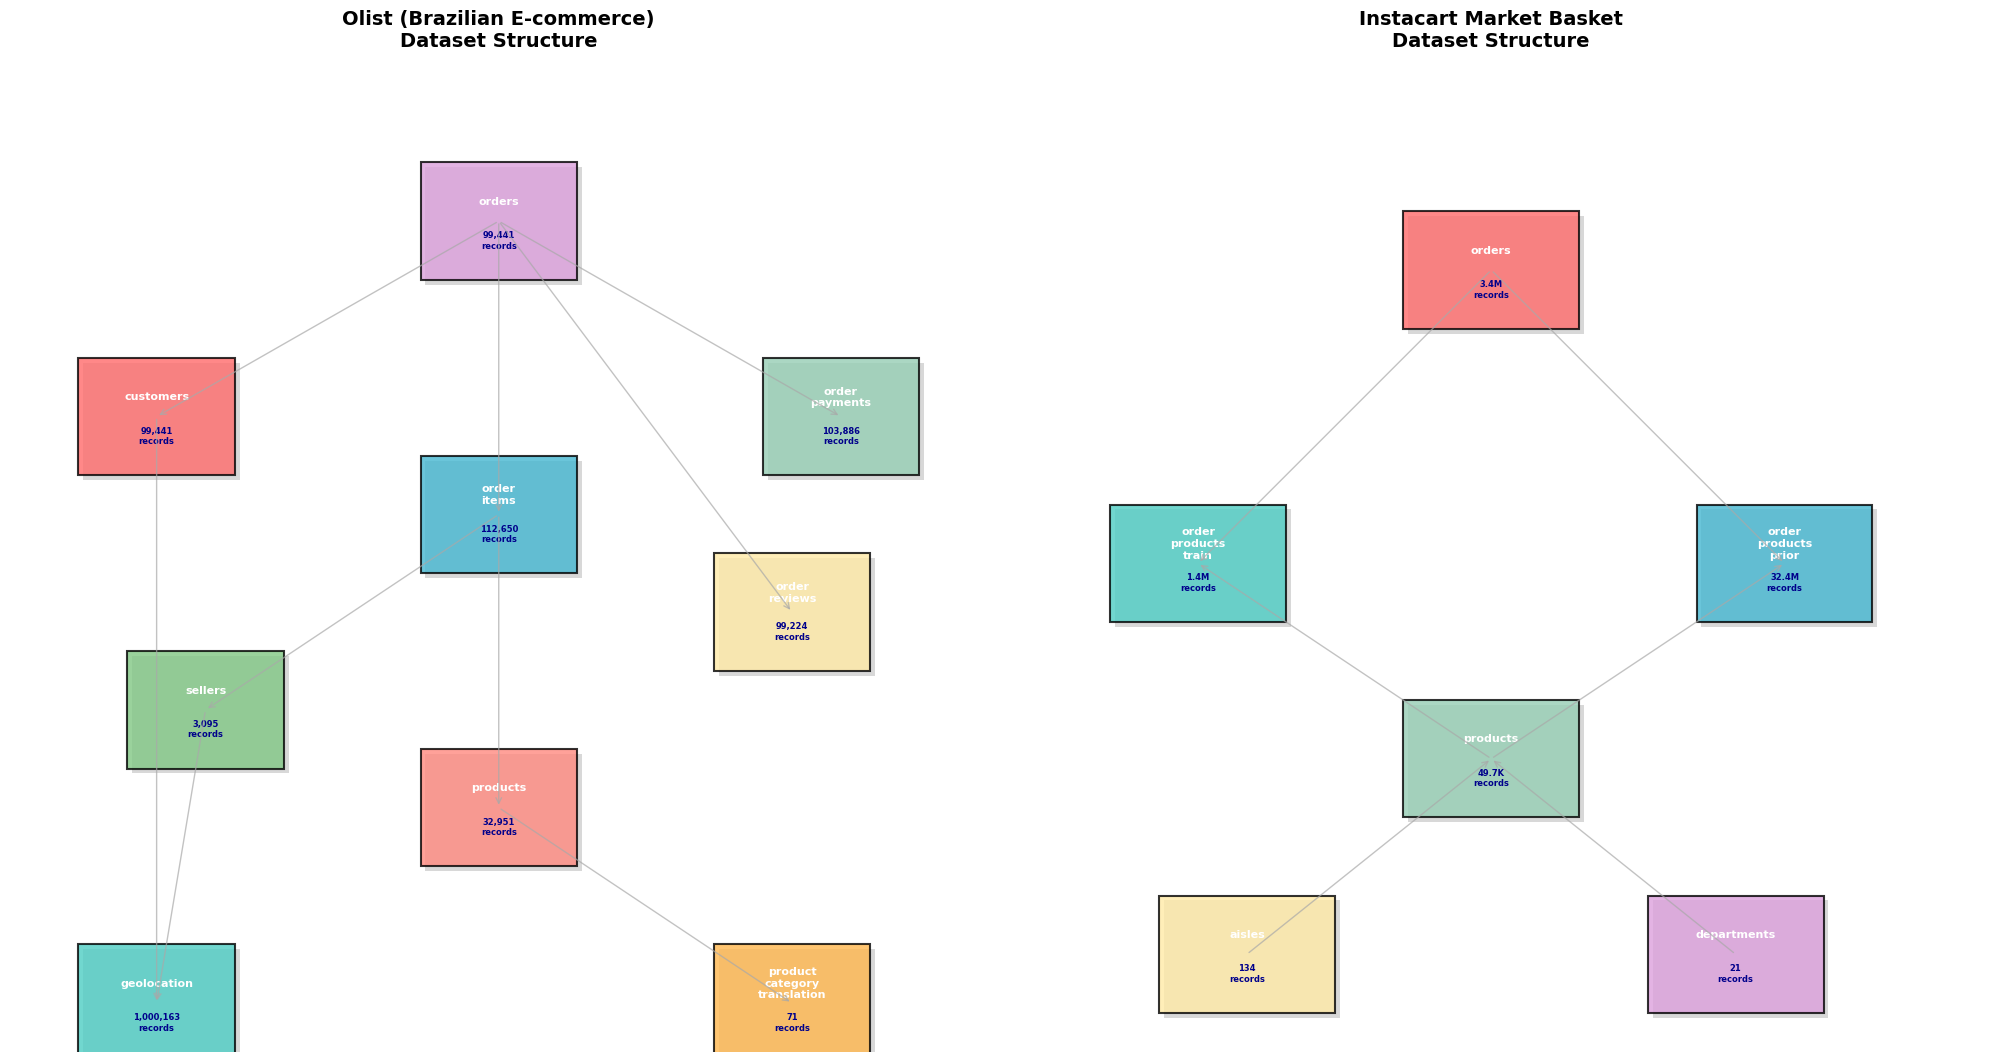

In [8]:
# Create Side-by-Side Comparison of Olist vs Instacart Datasets
def create_dataset_comparison():
    """
    Creates a comprehensive comparison between Olist and Instacart datasets
    showing their structures, similarities, and differences
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
    
    # --- OLIST (Brazilian E-commerce) DIAGRAM ---
    # Define positions for Olist tables
    olist_positions = {
        'orders': (0.5, 0.85),
        'customers': (0.15, 0.65),
        'order_items': (0.5, 0.55),
        'order_payments': (0.85, 0.65),
        'order_reviews': (0.8, 0.45),
        'products': (0.5, 0.25),
        'sellers': (0.2, 0.35),
        'geolocation': (0.15, 0.05),
        'product_category_translation': (0.8, 0.05)
    }
    
    # Olist table info with actual data
    olist_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#FF8A80', '#81C784', '#FFB74D']
    olist_table_info = {}
    
    for i, (name, df) in enumerate(datasets.items()):
        olist_table_info[name] = {
            'color': olist_colors[i % len(olist_colors)],
            'records': f"{df.shape[0]:,}",
            'columns': df.shape[1]
        }
    
    # Draw Olist tables
    for table_name, pos in olist_positions.items():
        if table_name not in olist_table_info:
            continue
            
        x, y = pos
        info = olist_table_info[table_name]
        
        # Table dimensions
        box_width = 0.16
        box_height = 0.12
        
        # Draw shadow
        shadow = plt.Rectangle((x - box_width/2 + 0.005, y - box_height/2 - 0.005), 
                              box_width, box_height, facecolor='gray', alpha=0.3)
        ax1.add_patch(shadow)
        
        # Draw main box
        rect = plt.Rectangle((x - box_width/2, y - box_height/2), box_width, box_height, 
                            facecolor=info['color'], edgecolor='black', linewidth=1.5, alpha=0.8)
        ax1.add_patch(rect)
        
        # Add table name
        display_name = table_name.replace('_', '\n')
        ax1.text(x, y + 0.02, display_name, ha='center', va='center', 
                fontweight='bold', fontsize=8, color='white')
        
        # Add record count
        ax1.text(x, y - 0.02, f"{info['records']}\nrecords", ha='center', va='center', 
                fontsize=6, color='darkblue', fontweight='bold')
    
    # Draw Olist relationships
    olist_relationships = [
        ('orders', 'customers'), ('orders', 'order_items'), ('orders', 'order_payments'),
        ('orders', 'order_reviews'), ('order_items', 'products'), ('order_items', 'sellers'),
        ('customers', 'geolocation'), ('sellers', 'geolocation'), 
        ('products', 'product_category_translation')
    ]
    
    for source, target in olist_relationships:
        if source in olist_positions and target in olist_positions:
            x1, y1 = olist_positions[source]
            x2, y2 = olist_positions[target]
            ax1.annotate('', xy=(x2, y2), xytext=(x1, y1),
                        arrowprops=dict(arrowstyle='->', lw=1, color='darkgray', alpha=0.7))
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.set_aspect('equal')
    ax1.axis('off')
    ax1.set_title('Olist (Brazilian E-commerce)\nDataset Structure', fontsize=14, fontweight='bold', pad=20)
    
    # --- INSTACART DIAGRAM ---
    # Define positions for Instacart tables
    instacart_positions = {
        'orders': (0.5, 0.8),
        'order_products_train': (0.2, 0.5),
        'order_products_prior': (0.8, 0.5),
        'products': (0.5, 0.3),
        'aisles': (0.25, 0.1),
        'departments': (0.75, 0.1)
    }
    
    # Instacart table info (typical sizes)
    instacart_table_info = {
        'orders': {'color': '#FF6B6B', 'records': '3.4M', 'columns': 7},
        'order_products_train': {'color': '#4ECDC4', 'records': '1.4M', 'columns': 4},
        'order_products_prior': {'color': '#45B7D1', 'records': '32.4M', 'columns': 4},
        'products': {'color': '#96CEB4', 'records': '49.7K', 'columns': 4},
        'aisles': {'color': '#FFEAA7', 'records': '134', 'columns': 2},
        'departments': {'color': '#DDA0DD', 'records': '21', 'columns': 2}
    }
    
    # Draw Instacart tables
    for table_name, pos in instacart_positions.items():
        x, y = pos
        info = instacart_table_info[table_name]
        
        # Table dimensions
        box_width = 0.18
        box_height = 0.12
        
        # Draw shadow
        shadow = plt.Rectangle((x - box_width/2 + 0.005, y - box_height/2 - 0.005), 
                              box_width, box_height, facecolor='gray', alpha=0.3)
        ax2.add_patch(shadow)
        
        # Draw main box
        rect = plt.Rectangle((x - box_width/2, y - box_height/2), box_width, box_height, 
                            facecolor=info['color'], edgecolor='black', linewidth=1.5, alpha=0.8)
        ax2.add_patch(rect)
        
        # Add table name
        display_name = table_name.replace('_', '\n')
        ax2.text(x, y + 0.02, display_name, ha='center', va='center', 
                fontweight='bold', fontsize=8, color='white')
        
        # Add record count
        ax2.text(x, y - 0.02, f"{info['records']}\nrecords", ha='center', va='center', 
                fontsize=6, color='darkblue', fontweight='bold')
    
    # Draw Instacart relationships
    instacart_relationships = [
        ('orders', 'order_products_train'), ('orders', 'order_products_prior'),
        ('products', 'order_products_train'), ('products', 'order_products_prior'),
        ('aisles', 'products'), ('departments', 'products')
    ]
    
    for source, target in instacart_relationships:
        x1, y1 = instacart_positions[source]
        x2, y2 = instacart_positions[target]
        ax2.annotate('', xy=(x2, y2), xytext=(x1, y1),
                    arrowprops=dict(arrowstyle='->', lw=1, color='darkgray', alpha=0.7))
    
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.set_aspect('equal')
    ax2.axis('off')
    ax2.set_title('Instacart Market Basket\nDataset Structure', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()

# Create the comparison visualization
create_dataset_comparison()

In [9]:
# Create Detailed Comparison Analysis
def create_detailed_comparison():
    """
    Creates a comprehensive comparison table and analysis between Olist and Instacart datasets
    """
    # Calculate actual statistics from loaded Olist data
    total_olist_records = sum(df.shape[0] for df in datasets.values())
    total_olist_tables = len(datasets)
    
    # Create comparison data
    comparison_data = {
        'Aspect': [
            'Dataset Origin', 'Business Model', 'Geographic Coverage', 'Time Period', 
            'Number of Tables', 'Total Records', 'Primary Focus', 'Customer Data',
            'Product Categories', 'Payment Info', 'Review System', 'Seller Info',
            'Geographic Data', 'Order Complexity', 'Main Use Cases'
        ],
        'Olist (Brazilian E-commerce)': [
            'Real marketplace data from Brazil', 'Multi-vendor marketplace', 'Brazil (nationwide)', '2016-2018',
            f'{total_olist_tables} tables', f'{total_olist_records:,} records', 'Complete e-commerce pipeline',
            'Customer demographics & location', 'Detailed product categorization', 'Multiple payment methods & installments',
            'Detailed reviews with scores', 'Seller demographics & performance', 'Precise geolocation coordinates',
            'Multi-item orders with multiple sellers', 'Business analytics, seller performance, customer satisfaction'
        ],
        'Instacart (Grocery Delivery)': [
            'Anonymized grocery delivery data', 'Grocery delivery service', 'USA (multiple cities)', '~2017',
            '6 tables', '~37M records', 'Market basket analysis',
            'Anonymized user behavior only', 'Grocery aisles & departments', 'No payment information',
            'No review system', 'No seller information', 'No geographic data',
            'Shopping cart optimization', 'Recommendation systems, reorder prediction, market basket analysis'
        ]
    }
    
    # Create DataFrame for better display
    comparison_df = pd.DataFrame(comparison_data)
    
    # Display the comparison table
    print("="*120)
    print("COMPREHENSIVE DATASET COMPARISON: OLIST vs INSTACART")
    print("="*120)
    
    for i, row in comparison_df.iterrows():
        print(f"\n🔍 {row['Aspect'].upper()}")
        print(f"   Olist:     {row['Olist (Brazilian E-commerce)']}")
        print(f"   Instacart: {row['Instacart (Grocery Delivery)']}")
        print("-" * 80)
    
    return comparison_df

# Create the detailed comparison
comparison_table = create_detailed_comparison()

COMPREHENSIVE DATASET COMPARISON: OLIST vs INSTACART

🔍 DATASET ORIGIN
   Olist:     Real marketplace data from Brazil
   Instacart: Anonymized grocery delivery data
--------------------------------------------------------------------------------

🔍 BUSINESS MODEL
   Olist:     Multi-vendor marketplace
   Instacart: Grocery delivery service
--------------------------------------------------------------------------------

🔍 GEOGRAPHIC COVERAGE
   Olist:     Brazil (nationwide)
   Instacart: USA (multiple cities)
--------------------------------------------------------------------------------

🔍 TIME PERIOD
   Olist:     2016-2018
   Instacart: ~2017
--------------------------------------------------------------------------------

🔍 NUMBER OF TABLES
   Olist:     9 tables
   Instacart: 6 tables
--------------------------------------------------------------------------------

🔍 TOTAL RECORDS
   Olist:     1,550,922 records
   Instacart: ~37M records
---------------------------------------

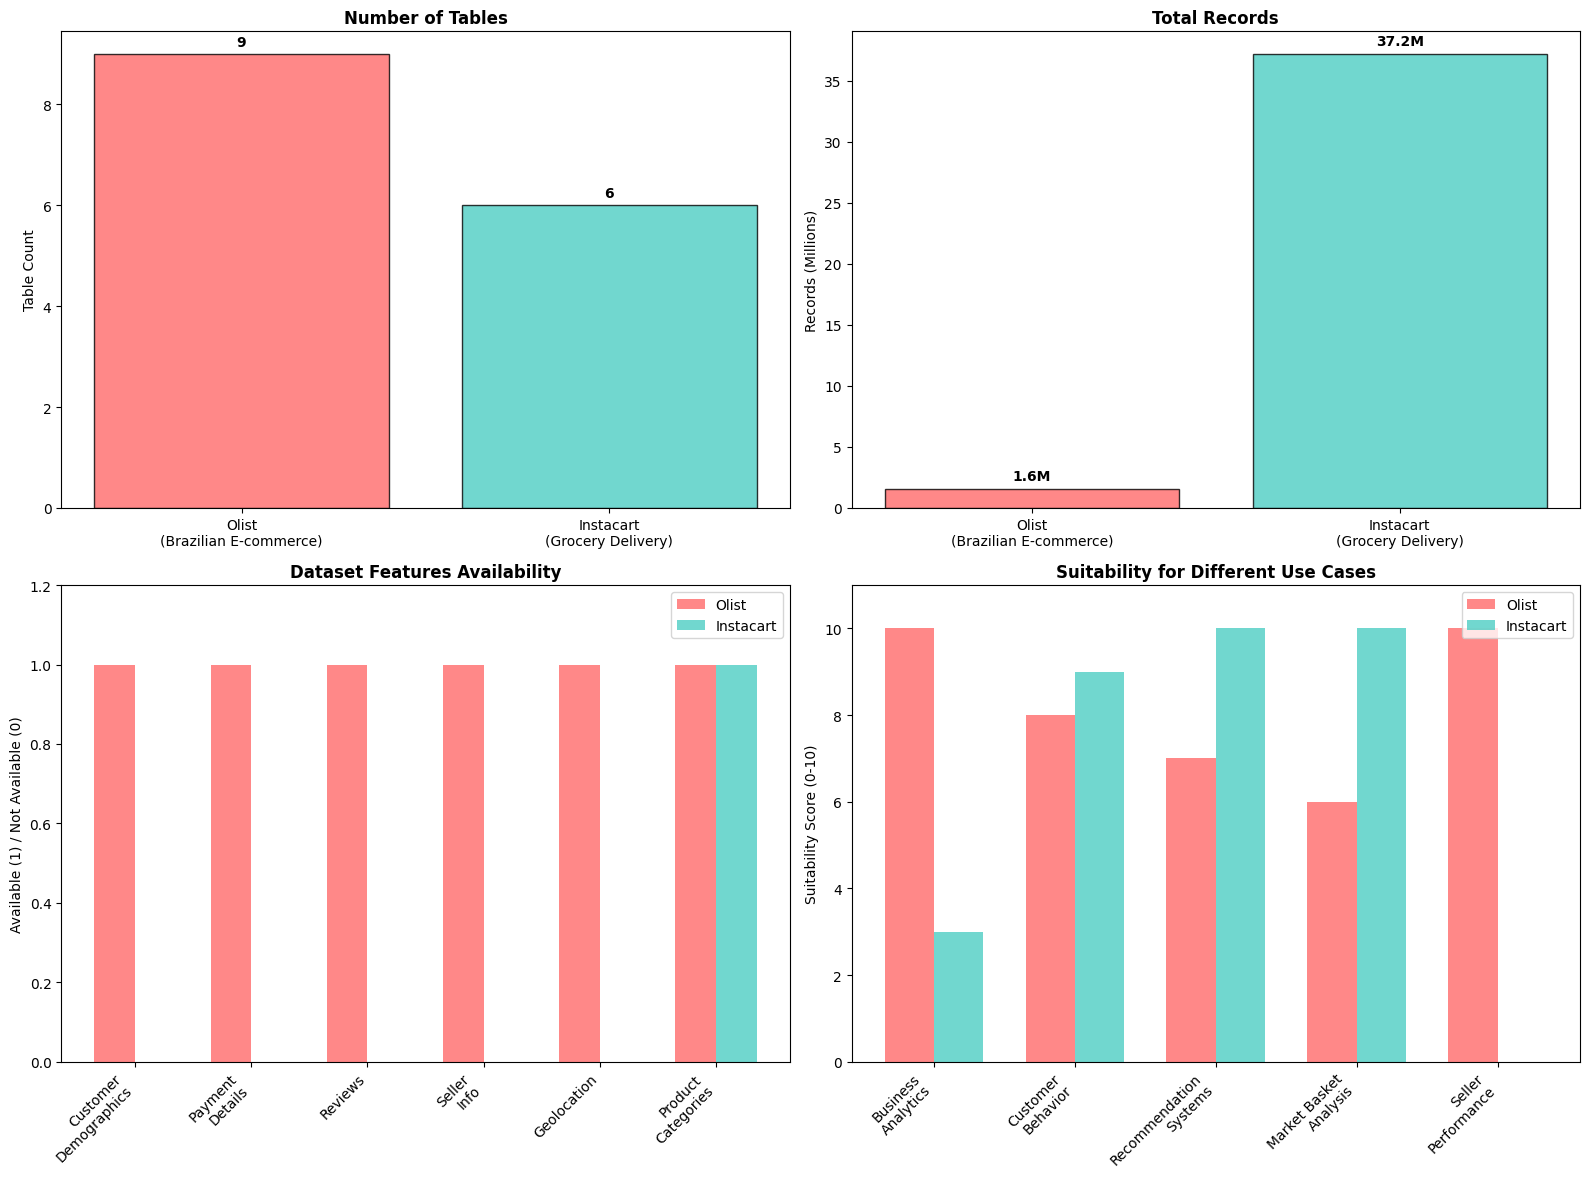


KEY INSIGHTS FROM COMPARISON

🎯 OLIST STRENGTHS:
• Complete e-commerce ecosystem with all business aspects
• Rich seller and payment information for marketplace analysis
• Geographic data for location-based insights
• Customer demographics and review system
• Perfect for: Business analytics, marketplace optimization, seller performance

🎯 INSTACART STRENGTHS:
• Massive scale (37M+ records) for machine learning
• Clean, focused dataset for recommendation systems
• Excellent for market basket analysis and reorder prediction
• High-quality product categorization (aisles/departments)
• Perfect for: ML models, recommendation engines, consumer behavior

🔄 COMPLEMENTARY USAGE:
• Use Olist for understanding complete e-commerce business operations
• Use Instacart for developing recommendation and prediction algorithms
• Both valuable for different aspects of e-commerce data science
    


In [10]:
# Create Visual Comparison Charts
def create_comparison_charts():
    """
    Creates visual charts comparing key aspects of both datasets
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Chart 1: Table Count Comparison
    datasets_names = ['Olist\n(Brazilian E-commerce)', 'Instacart\n(Grocery Delivery)']
    table_counts = [len(datasets), 6]
    colors1 = ['#FF6B6B', '#4ECDC4']
    
    bars1 = ax1.bar(datasets_names, table_counts, color=colors1, alpha=0.8, edgecolor='black')
    ax1.set_title('Number of Tables', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Table Count')
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    # Chart 2: Record Volume Comparison (in millions)
    total_olist = sum(df.shape[0] for df in datasets.values()) / 1_000_000
    total_instacart = 37.2  # Approximate total for Instacart
    record_counts = [total_olist, total_instacart]
    
    bars2 = ax2.bar(datasets_names, record_counts, color=colors1, alpha=0.8, edgecolor='black')
    ax2.set_title('Total Records', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Records (Millions)')
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}M', ha='center', va='bottom', fontweight='bold')
    
    # Chart 3: Dataset Complexity (features available)
    features = ['Customer\nDemographics', 'Payment\nDetails', 'Reviews', 'Seller\nInfo', 'Geolocation', 'Product\nCategories']
    olist_features = [1, 1, 1, 1, 1, 1]  # Has all features
    instacart_features = [0, 0, 0, 0, 0, 1]  # Only has product categories
    
    x = np.arange(len(features))
    width = 0.35
    
    bars3a = ax3.bar(x - width/2, olist_features, width, label='Olist', color='#FF6B6B', alpha=0.8)
    bars3b = ax3.bar(x + width/2, instacart_features, width, label='Instacart', color='#4ECDC4', alpha=0.8)
    
    ax3.set_title('Dataset Features Availability', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Available (1) / Not Available (0)')
    ax3.set_xticks(x)
    ax3.set_xticklabels(features, rotation=45, ha='right')
    ax3.legend()
    ax3.set_ylim(0, 1.2)
    
    # Chart 4: Primary Use Cases
    use_cases = ['Business\nAnalytics', 'Customer\nBehavior', 'Recommendation\nSystems', 'Market Basket\nAnalysis', 'Seller\nPerformance']
    olist_strength = [10, 8, 7, 6, 10]  # Olist strengths (out of 10)
    instacart_strength = [3, 9, 10, 10, 0]  # Instacart strengths (out of 10)
    
    x = np.arange(len(use_cases))
    bars4a = ax4.bar(x - width/2, olist_strength, width, label='Olist', color='#FF6B6B', alpha=0.8)
    bars4b = ax4.bar(x + width/2, instacart_strength, width, label='Instacart', color='#4ECDC4', alpha=0.8)
    
    ax4.set_title('Suitability for Different Use Cases', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Suitability Score (0-10)')
    ax4.set_xticks(x)
    ax4.set_xticklabels(use_cases, rotation=45, ha='right')
    ax4.legend()
    ax4.set_ylim(0, 11)
    
    plt.tight_layout()
    plt.show()
    
    # Summary insights
    print("\n" + "="*80)
    print("KEY INSIGHTS FROM COMPARISON")
    print("="*80)
    print("""
🎯 OLIST STRENGTHS:
• Complete e-commerce ecosystem with all business aspects
• Rich seller and payment information for marketplace analysis
• Geographic data for location-based insights
• Customer demographics and review system
• Perfect for: Business analytics, marketplace optimization, seller performance

🎯 INSTACART STRENGTHS:
• Massive scale (37M+ records) for machine learning
• Clean, focused dataset for recommendation systems
• Excellent for market basket analysis and reorder prediction
• High-quality product categorization (aisles/departments)
• Perfect for: ML models, recommendation engines, consumer behavior

🔄 COMPLEMENTARY USAGE:
• Use Olist for understanding complete e-commerce business operations
• Use Instacart for developing recommendation and prediction algorithms
• Both valuable for different aspects of e-commerce data science
    """)

# Create the comparison charts
create_comparison_charts()

## Summary: Choosing Between Olist and Instacart Datasets

### 🏆 **When to Use Olist (Brazilian E-commerce)**
- **Complete Business Analytics**: Understanding all aspects of e-commerce operations
- **Marketplace Research**: Multi-vendor platform dynamics and seller performance
- **Customer Journey Analysis**: From order placement to delivery and reviews
- **Geographic Analysis**: Location-based insights and logistics optimization
- **Payment Behavior**: Understanding installment payments and payment methods
- **Academic Research**: Comprehensive dataset for e-commerce studies

### 🏆 **When to Use Instacart (Grocery Delivery)**
- **Machine Learning Projects**: Large-scale data for robust model training
- **Recommendation Systems**: Predicting what customers will buy next
- **Market Basket Analysis**: Understanding product associations and bundles
- **Reorder Prediction**: Forecasting repeat purchases
- **Consumer Behavior**: Analyzing shopping patterns and preferences
- **Algorithm Development**: Clean, focused dataset for ML experimentation

### 🎯 **Key Decision Factors**

| Factor | Choose Olist | Choose Instacart |
|--------|--------------|------------------|
| **Data Completeness** | ✅ Rich, multi-dimensional | ❌ Limited to shopping behavior |
| **Scale** | ❌ Smaller (~1.8M records) | ✅ Massive (37M+ records) |
| **Business Context** | ✅ Complete marketplace view | ❌ Limited business context |
| **ML Readiness** | ⚠️ Requires preprocessing | ✅ Clean, ML-ready |
| **Real-world Application** | ✅ Direct business insights | ✅ Algorithm development |
| **Geographic Diversity** | ❌ Brazil only | ✅ USA multi-city |

### 💡 **Recommendation**
- **For Business Analysis**: Start with Olist for comprehensive insights
- **For ML/Data Science**: Use Instacart for algorithm development
- **For Complete Projects**: Consider using both datasets for different phases
- **For Learning**: Olist provides better understanding of e-commerce complexity